<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [6]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from math import sqrt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
from IPython.display import clear_output
sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [7]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

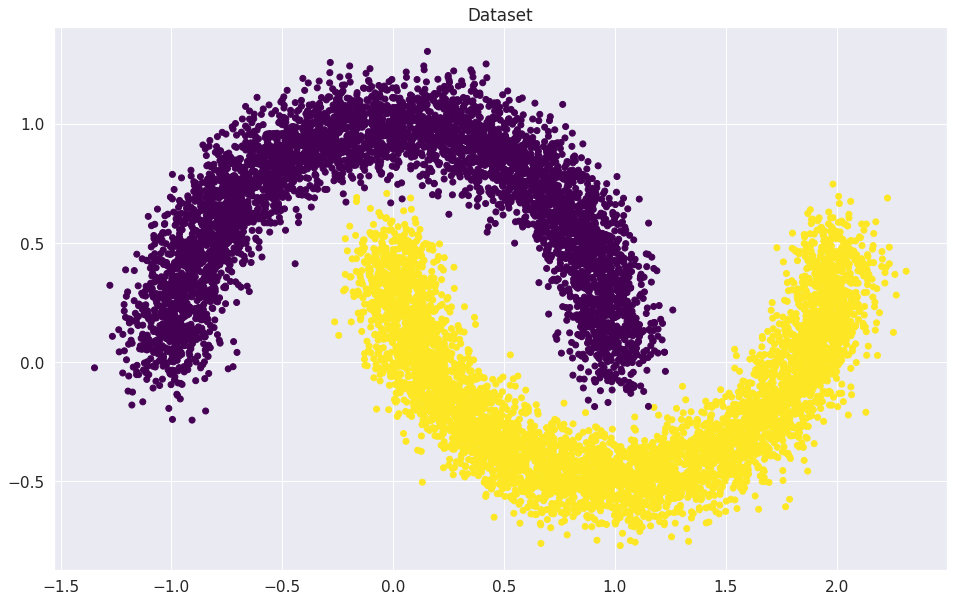

In [8]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [10]:
X_train

array([[ 0.50202001, -0.33758011],
       [-0.02001968,  0.239079  ],
       [ 0.57026061,  0.81166576],
       ...,
       [ 0.32163146, -0.35671524],
       [ 2.01344205,  0.03227946],
       [ 0.17908235,  0.93097468]])

In [11]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [12]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [13]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features , out_features))
        self.bias = bias
        if bias:
            self.bias_term = torch.zeros(out_features)

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [14]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [15]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(linear_regression)

2

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [16]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp,y_batch[:,None])
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.1953125
Iteration: 100
Batch accuracy: 0.671875
Iteration: 200
Batch accuracy: 0.765625
Iteration: 300
Batch accuracy: 0.859375
Iteration: 400
Batch accuracy: 0.84375
Iteration: 500
Batch accuracy: 0.875
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125
Iteration: 800
Batch accuracy: 0.84375

Iteration: 873.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 873

### Визуализируем результаты

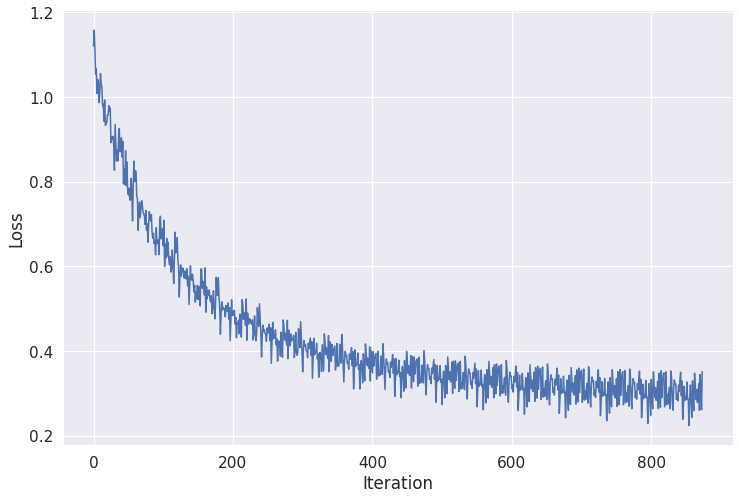

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

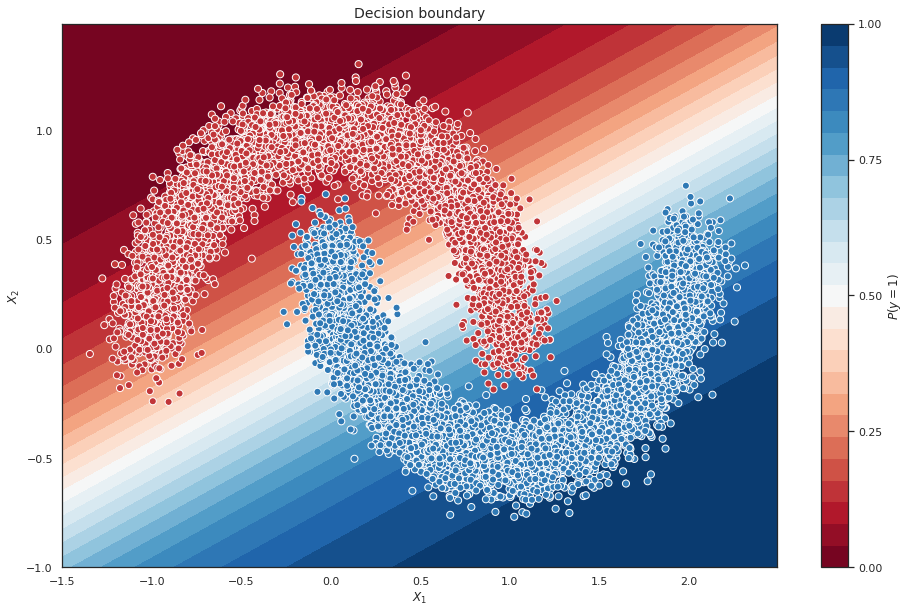

In [18]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [19]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch)
        probabilities =  torch.sigmoid(preds)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val_t , predict(val_dataloader,linear_regression))

0.868

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.868

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [21]:
import os
from torchvision.datasets import MNIST

data_tfs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128


train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [22]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),
    nn.ELU(),
    nn.Linear(256,128),
    nn.ELU(),
    nn.Linear(128,10)
)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [25]:
torch.cuda.empty_cache()

### Задание. Дополните цикл обучения.

In [26]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()  
                with torch.no_grad():  
                    outp = model(x_batch.to(device))    
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).float().sum()
            all  = preds.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8847155448717948
Loader: valid. Accuracy: 0.9331931089743589
Epoch: 2
Loader: train. Accuracy: 0.9472155448717948
Loader: valid. Accuracy: 0.9519230769230769
Epoch: 3
Loader: train. Accuracy: 0.9641760149572649
Loader: valid. Accuracy: 0.9573317307692307
Epoch: 4
Loader: train. Accuracy: 0.9713207799145299
Loader: valid. Accuracy: 0.9665464743589743
Epoch: 5
Loader: train. Accuracy: 0.9771467681623932
Loader: valid. Accuracy: 0.9701522435897436
Epoch: 6
Loader: train. Accuracy: 0.9815204326923077
Loader: valid. Accuracy: 0.9709535256410257
Epoch: 7
Loader: train. Accuracy: 0.9845920138888888
Loader: valid. Accuracy: 0.9744591346153846
Epoch: 8
Loader: train. Accuracy: 0.9868456196581197
Loader: valid. Accuracy: 0.9707532051282052
Epoch: 9
Loader: train. Accuracy: 0.9858940972222222
Loader: valid. Accuracy: 0.9671474358974359
Epoch: 10
Loader: train. Accuracy: 0.9861611912393162
Loader: valid. Accuracy: 0.9684495192307693


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [27]:
elu_accuracy = accuracy["valid"]

In [28]:
elu_accuracy

[0.9331931089743589,
 0.9519230769230769,
 0.9573317307692307,
 0.9665464743589743,
 0.9701522435897436,
 0.9709535256410257,
 0.9744591346153846,
 0.9707532051282052,
 0.9671474358974359,
 0.9684495192307693]

## Identical

In [29]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),
    Identical(),
    nn.Linear(256,128),
    Identical(),
    nn.Linear(128,10)
)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()  
                with torch.no_grad():  
                    outp = model(x_batch.to(device))    
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).float().sum()
            all  = preds.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.861862313034188
Loader: valid. Accuracy: 0.8835136217948718
Epoch: 2
Loader: train. Accuracy: 0.8924445779914529
Loader: valid. Accuracy: 0.8938301282051282
Epoch: 3
Loader: train. Accuracy: 0.8974025106837606
Loader: valid. Accuracy: 0.8958333333333334
Epoch: 4
Loader: train. Accuracy: 0.9000233707264957
Loader: valid. Accuracy: 0.8942307692307693
Epoch: 5
Loader: train. Accuracy: 0.9018596420940171
Loader: valid. Accuracy: 0.8969350961538461
Epoch: 6
Loader: train. Accuracy: 0.903145032051282
Loader: valid. Accuracy: 0.8987379807692307
Epoch: 7
Loader: train. Accuracy: 0.9047976762820513
Loader: valid. Accuracy: 0.8995392628205128
Epoch: 8
Loader: train. Accuracy: 0.9064169337606838
Loader: valid. Accuracy: 0.9001402243589743
Epoch: 9
Loader: train. Accuracy: 0.9076856303418803
Loader: valid. Accuracy: 0.9003405448717948
Epoch: 10
Loader: train. Accuracy: 0.9090878739316239
Loader: valid. Accuracy: 0.9011418269230769


In [30]:
plain_accuracy= accuracy["valid"]

In [31]:
plain_accuracy

[0.8835136217948718,
 0.8938301282051282,
 0.8958333333333334,
 0.8942307692307693,
 0.8969350961538461,
 0.8987379807692307,
 0.8995392628205128,
 0.9001402243589743,
 0.9003405448717948,
 0.9011418269230769]

## ReLU

In [32]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,10)
)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()  
                with torch.no_grad():  
                    outp = model(x_batch.to(device))    
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).float().sum()
            all  = preds.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8724626068376068
Loader: valid. Accuracy: 0.9321915064102564
Epoch: 2
Loader: train. Accuracy: 0.9406216613247863
Loader: valid. Accuracy: 0.9512219551282052
Epoch: 3
Loader: train. Accuracy: 0.9597188835470085
Loader: valid. Accuracy: 0.9619391025641025
Epoch: 4
Loader: train. Accuracy: 0.9689670138888888
Loader: valid. Accuracy: 0.9671474358974359
Epoch: 5
Loader: train. Accuracy: 0.9739750267094017
Loader: valid. Accuracy: 0.9699519230769231
Epoch: 6
Loader: train. Accuracy: 0.9772302350427351
Loader: valid. Accuracy: 0.9677483974358975
Epoch: 7
Loader: train. Accuracy: 0.9810697115384616
Loader: valid. Accuracy: 0.9644431089743589
Epoch: 8
Loader: train. Accuracy: 0.9835069444444444
Loader: valid. Accuracy: 0.9616386217948718
Epoch: 9
Loader: train. Accuracy: 0.9857772435897436
Loader: valid. Accuracy: 0.9707532051282052
Epoch: 10
Loader: train. Accuracy: 0.9855101495726496
Loader: valid. Accuracy: 0.9701522435897436


In [33]:
relu_accuracy = accuracy["valid"]

In [34]:
relu_accuracy

[0.9321915064102564,
 0.9512219551282052,
 0.9619391025641025,
 0.9671474358974359,
 0.9699519230769231,
 0.9677483974358975,
 0.9644431089743589,
 0.9616386217948718,
 0.9707532051282052,
 0.9701522435897436]

## LeakyReLU

In [35]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,10)
)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()  
                with torch.no_grad():  
                    outp = model(x_batch.to(device))    
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).float().sum()
            all  = preds.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.873848157051282
Loader: valid. Accuracy: 0.9234775641025641
Epoch: 2
Loader: train. Accuracy: 0.9379340277777778
Loader: valid. Accuracy: 0.9543269230769231
Epoch: 3
Loader: train. Accuracy: 0.9576655982905983
Loader: valid. Accuracy: 0.9609375
Epoch: 4
Loader: train. Accuracy: 0.9667467948717948
Loader: valid. Accuracy: 0.9639423076923077
Epoch: 5
Loader: train. Accuracy: 0.9730568910256411
Loader: valid. Accuracy: 0.9639423076923077
Epoch: 6
Loader: train. Accuracy: 0.9772803151709402
Loader: valid. Accuracy: 0.9620392628205128
Epoch: 7
Loader: train. Accuracy: 0.9809862446581197
Loader: valid. Accuracy: 0.965645032051282
Epoch: 8
Loader: train. Accuracy: 0.982688969017094
Loader: valid. Accuracy: 0.9653445512820513
Epoch: 9
Loader: train. Accuracy: 0.9846087072649573
Loader: valid. Accuracy: 0.9669471153846154
Epoch: 10
Loader: train. Accuracy: 0.9861278044871795
Loader: valid. Accuracy: 0.9690504807692307


In [36]:
leaky_relu_accuracy = accuracy["valid"]

In [37]:
leaky_relu_accuracy

[0.9234775641025641,
 0.9543269230769231,
 0.9609375,
 0.9639423076923077,
 0.9639423076923077,
 0.9620392628205128,
 0.965645032051282,
 0.9653445512820513,
 0.9669471153846154,
 0.9690504807692307]

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

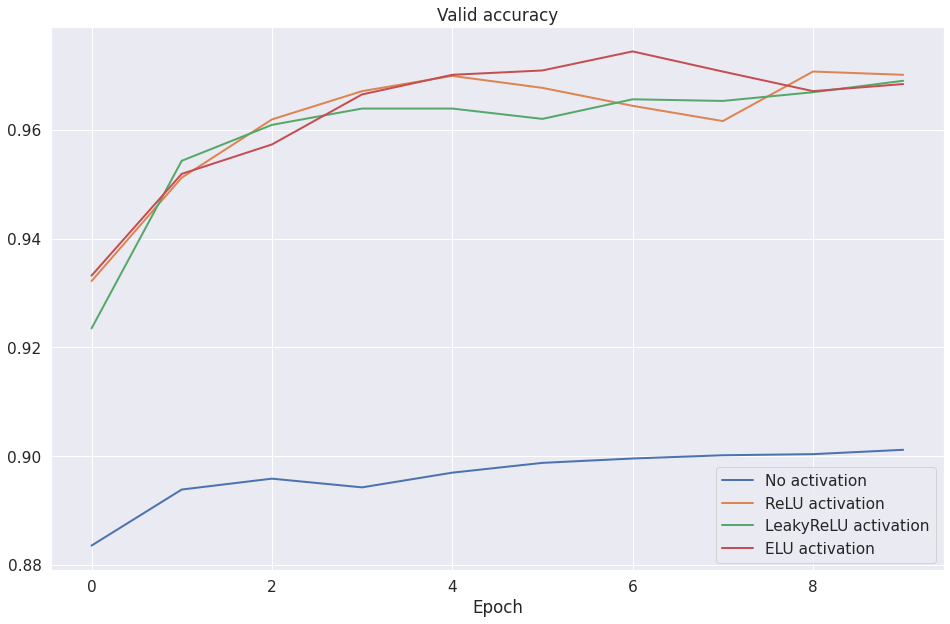

In [38]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

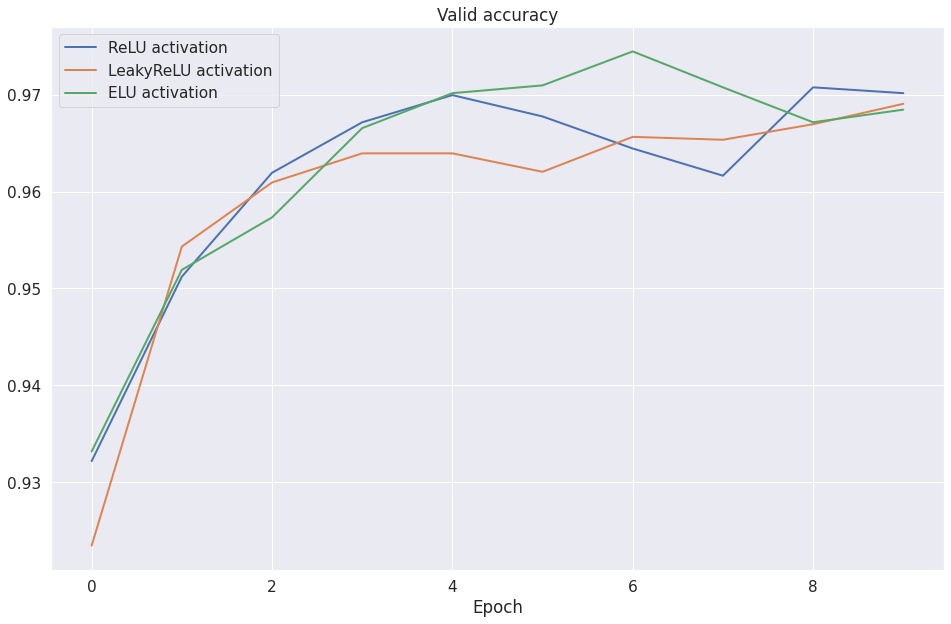

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [40]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-11-03 14:53:42--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-11-03 14:53:44--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   120KB/s    in 0.4s    

2022-11-03 14:53:45 (120 KB/s) - ‘sample_photo.jpg’ saved [49337/4

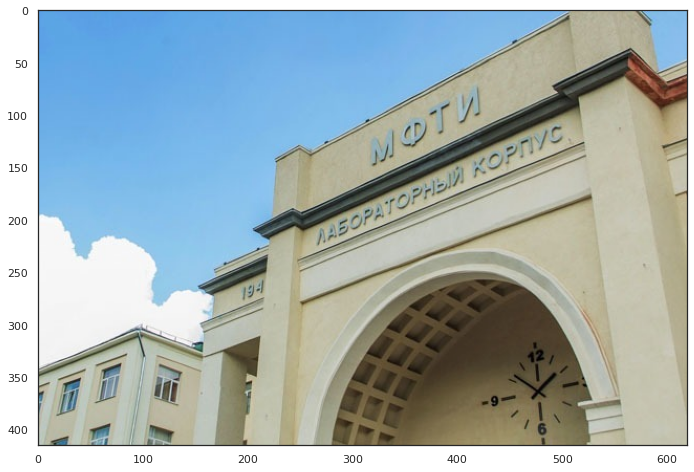

In [41]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [42]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

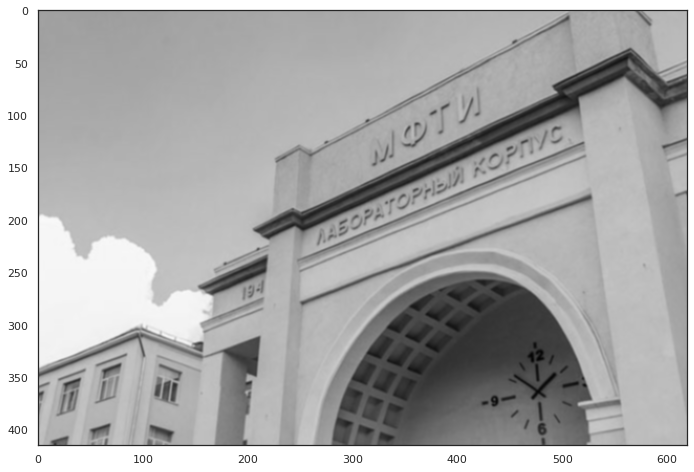

In [43]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** А3 Б4 В5 Г6 Д2 Е1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [44]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.relu= nn.ReLU()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(6,16,3)
        self.pool2 = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x =self.relu(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x =self.relu(x)

        x = self.fc2(x)
        x =self.relu(x)

        x = self.fc3(x)
        return x

In [45]:
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [46]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()  
                with torch.no_grad():  
                    outp = model(x_batch.to(device))    
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).float().sum()
            all  = preds.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8702090010683761
Loader: valid. Accuracy: 0.9600360576923077
Epoch: 2
Loader: train. Accuracy: 0.9629907852564102
Loader: valid. Accuracy: 0.9738581730769231
Epoch: 3
Loader: train. Accuracy: 0.9743589743589743
Loader: valid. Accuracy: 0.9797676282051282
Epoch: 4
Loader: train. Accuracy: 0.9804520566239316
Loader: valid. Accuracy: 0.9827724358974359
Epoch: 5
Loader: train. Accuracy: 0.984107905982906
Loader: valid. Accuracy: 0.983573717948718
Epoch: 6
Loader: train. Accuracy: 0.9865618322649573
Loader: valid. Accuracy: 0.9830729166666666
Epoch: 7
Loader: train. Accuracy: 0.9883480235042735
Loader: valid. Accuracy: 0.9825721153846154
Epoch: 8
Loader: train. Accuracy: 0.9901008279914529
Loader: valid. Accuracy: 0.9832732371794872
Epoch: 9
Loader: train. Accuracy: 0.9914362980769231
Loader: valid. Accuracy: 0.9850761217948718
Epoch: 10
Loader: train. Accuracy: 0.9927550747863247
Loader: valid. Accuracy: 0.9859775641025641


In [47]:
lenet_accuracy = accuracy["valid"]

In [49]:
lenet_accuracy

[0.9600360576923077,
 0.9738581730769231,
 0.9797676282051282,
 0.9827724358974359,
 0.983573717948718,
 0.9830729166666666,
 0.9825721153846154,
 0.9832732371794872,
 0.9850761217948718,
 0.9859775641025641]

Сравним с предыдущем пунктом

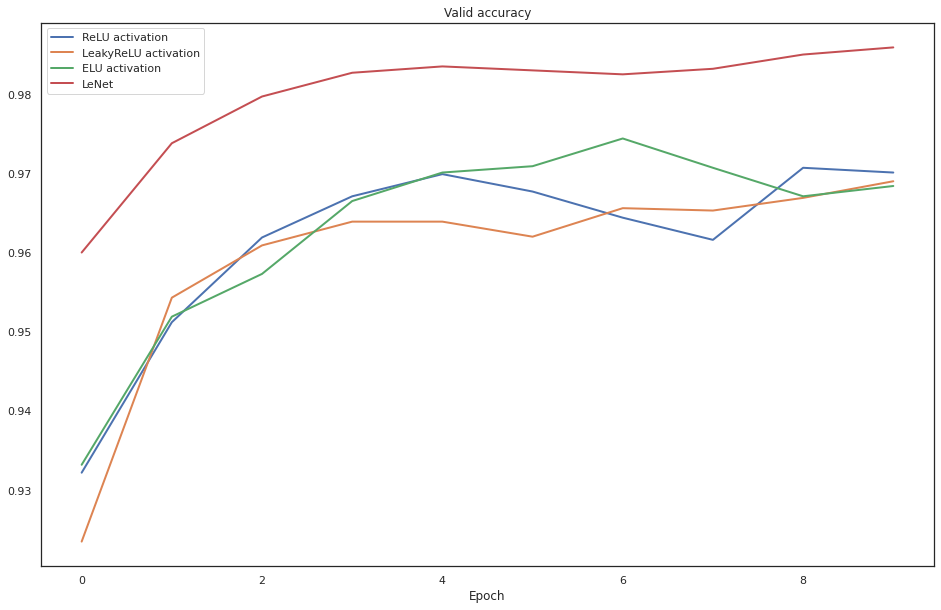

In [48]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99